# DATA MINING PROJECT: Analysis of a Supermarket’s Customers
## 1.2) Data Preparation
### *Antonio Strippoli, Valerio Mariani*

In [1]:
%matplotlib inline
import os
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from math import log, ceil
import matplotlib.pyplot as plt

pd.set_option('mode.chained_assignment', None)

In [2]:
def plot(ax, folder="cdf_plots", filename="", figsize=(6.4, 4.8)):
    fig = plt.gcf()
    fig.set_size_inches(*figsize)
    plt.tight_layout()
    if filename:
        path = os.path.join("..", "report", "imgs", folder)
        if not os.path.exists(path):
            os.mkdir(path)
        plt.savefig(os.path.join(path, filename))
    plt.show()
    plt.close()

In [3]:
# Load the secondary data
df = pd.read_csv('customer_supermarket_2.csv', index_col=0, parse_dates=["PurchaseDate"])

### Create a new dataset with a profilation of each customer.

In [ ]:
# Recency
recency = lambda g: (df['PurchaseDate'].max() - g['PurchaseDate'].max()).days
# Frequency
frequency = lambda g: g['BasketID'].nunique()
# Total money spent
monetary = lambda g: round( sum( g["Sale"]*g["Qta"] ), 2)
# Total purchased items
tot_items = lambda g: sum( g["Qta"] )
# Maximum number of purchased items in a shopping session
max_items = lambda g: max( [ sum( g1[1]["Qta"] ) for g1 in g.groupby("BasketID") ] )
# Medium object in basket
mean_items = lambda g: int( np.mean( [ sum( g1[1]["Qta"] ) for g1 in g.groupby("BasketID") ] ))
# Number of distinct items
unique_items = lambda g: g["ProdID"].nunique()
# Preferred item
preferred_item = lambda g: g.groupby('ProdID').agg({'Qta':'sum'}).idxmax()[0]
# Max amount for a basket
max_sale = lambda g: round( max( [ sum( g1[1]["Sale"]*g1[1]["Qta"] ) for g1 in g.groupby("BasketID") ] ), 2)
# Medium amount for a basket
mean_sale = lambda g: round( np.mean( [ sum( g1[1]["Sale"]*g1[1]["Qta"] ) for g1 in g.groupby( "BasketID" ) ] ), 2)
# Medium amount paid for an item
mean_item_sale = lambda g: round( np.mean( g["Sale"].unique() ), 2)
# Entropy
def entropy(g, attr1, attr2, groupby, op):
    l = g[[attr1, attr2]].groupby(groupby).agg(op)
    m = l.values.sum()
    e = -sum( [ (mi/m)*log((mi/m), 2) for mi in l.values.flatten() ] )
    return round(e, 2)
# Weekday preference
weekday_pref = lambda g: int(pd.Series(g['PurchaseDate'].unique()).apply(lambda x: x.weekday()).mean())
# Number of week of the month preference
weekmonth_pref = lambda g: int(pd.Series(g['PurchaseDate'].unique()).apply( lambda x: int(ceil(x.day/7.0)) ).mean())
# Main country
main_country = lambda g: g[['BasketID','CustomerCountry']].groupby('CustomerCountry').nunique().idxmax()[0]

In [ ]:
groups = df[df["Qta"]>0].groupby("CustomerID")
cdf = pd.DataFrame(data=np.array( [
    [
    group[0],
    recency(group[1]),
    frequency(group[1]),
    monetary(group[1]),
    tot_items(group[1]),
    max_items(group[1]),
    mean_items(group[1]),
    unique_items(group[1]),
    preferred_item(group[1]),
    max_sale(group[1]),
    mean_sale(group[1]),
    mean_item_sale(group[1]),
    entropy(group[1], "ProdID", 'Qta', 'ProdID', 'sum'),
    entropy(group[1], "ProdID", 'Sale', 'ProdID', 'sum'),
    weekday_pref(group[1]),
    weekmonth_pref(group[1]),
    main_country(group[1])
    ] for group in groups
] ), columns=["CustomerID","Recency","Frequency","Monetary","TotItems","MaxItems","MeanItems","UniqueItems","PrefItem","MaxSale","MeanSale","MeanItemSale","E-Qta","E-Sale","WeekDayPref","WeekMonthPref","MainCountry"] )
cdf.set_index('CustomerID', inplace=True)

# Workaround for Pandas' bug (not able to convert to correct dtypes)
# cdf.convert_dtypes()
cdf.to_csv("customer_profilation.csv")
cdf = pd.read_csv("customer_profilation.csv", index_col=0)

# calculate percentage of returned item for customer
groups = df[ (df["Qta"]<0) & ~(df["ProdID"].isin(['M', 'D', 'BANK CHARGES'])) ][['CustomerID','Qta']].groupby("CustomerID").agg('sum')
cdf['PReturn'] = pd.Series(
    [ round(-groups.loc[i]['Qta']/cdf.loc[i]['TotItems']*100, 2) if i in groups.index else 0 for i in cdf.index ],
    dtype='float64',
    index=cdf.index
)

print("N. ENTRIES:", len(cdf))
cdf.to_csv("customer_profilation.csv")

### Data Quality

In [4]:
cdf = pd.read_csv("customer_profilation.csv", index_col=0)

cdf.info()
cdf.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4329 entries, 12347 to 18287
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        4329 non-null   int64  
 1   Frequency      4329 non-null   int64  
 2   Monetary       4329 non-null   float64
 3   TotItems       4329 non-null   int64  
 4   MaxItems       4329 non-null   int64  
 5   MeanItems      4329 non-null   int64  
 6   UniqueItems    4329 non-null   int64  
 7   PrefItem       4329 non-null   object 
 8   MaxSale        4329 non-null   float64
 9   MeanSale       4329 non-null   float64
 10  MeanItemSale   4329 non-null   float64
 11  E-Qta          4329 non-null   float64
 12  E-Sale         4329 non-null   float64
 13  WeekDayPref    4329 non-null   int64  
 14  WeekMonthPref  4329 non-null   int64  
 15  MainCountry    4329 non-null   object 
 16  PReturn        4329 non-null   float64
dtypes: float64(7), int64(8), object(2)
memory usage

,Recency,Frequency,Monetary,TotItems,MaxItems,MeanItems,UniqueItems,MaxSale,MeanSale,MeanItemSale,E-Qta,E-Sale,WeekDayPref,WeekMonthPref,PReturn
count,4329.000000,4329.000000,4329.000000,4329.000000,4329.000000,4329.000000,4329.000000,4329.000000,4329.000000,4329.000000,4329.000000,4329.000000,4329.000000,4329.000000,4329.000000
mean,105.602449,4.165396,1704.370527,1013.707092,352.858397,223.355971,60.601756,560.392294,372.848626,5.409993,4.460483,4.425623,2.529453,2.445599,1.119727
std,115.085306,6.881449,4200.145687,2723.671393,549.806861,282.190720,79.673539,861.266155,432.646054,36.243457,1.653526,1.647647,1.504652,0.917765,6.251112
min,0.000000,1.000000,2.900000,1.000000,1.000000,1.000000,1.000000,2.900000,2.900000,0.140000,-0.000000,-0.000000,0.000000,1.000000,0.000000
25%,22.000000,1.000000,306.940000,160.000000,121.000000,93.000000,16.000000,222.990000,178.310000,2.730000,3.450000,3.400000,2.000000,2.000000,0.000000
50%,61.000000,2.000000,669.110000,378.000000,224.000000,161.000000,35.000000,367.160000,292.250000,3.670000,4.590000,4.530000,2.000000,2.000000,0.000000
75%,162.000000,5.000000,1649.500000,983.000000,406.000000,270.000000,77.000000,617.450000,428.220000,4.610000,5.630000,5.600000,3.000000,3.000000,0.170000
max,697.000000,209.000000,72882.090000,63312.000000,11848.000000,7824.000000,1768.000000,21535.900000,14844.770000,2033.100000,9.180000,9.360000,6.000000,5.000000,100.000000


In [ ]:
# Outliers in TotItems (users who purchased an abnormal number of items)
cdf_totitems = cdf['TotItems']
plot(cdf_totitems.plot.box(), figsize=(2, 4.8), folder="cdf_outliers", filename="TotItems_BP")
plot(sn.distplot(cdf_totitems[cdf_totitems < 25000], bins=100), folder="cdf_outliers", filename="TotItems_HIST")

# Search for a threshold
plot(cdf_totitems[cdf_totitems < 100000].plot.box(), figsize=(2, 4.8))
plot(cdf_totitems[cdf_totitems < 70000].plot.box(), figsize=(2, 4.8))

cdf = cdf[cdf_totitems < 70000]

In [ ]:
# Outliers in Monetary (users who spent way too much money)
cdf_monetary = cdf['Monetary']
plot(cdf_monetary.plot.box(), figsize=(2, 4.8), folder="cdf_outliers", filename="Monetary_BP")
plot(sn.distplot(cdf_monetary[cdf_monetary < 25000], bins=100), folder="cdf_outliers", filename="Monetary_HIST")

# Search for a threshold
plot(cdf_monetary[cdf_monetary < 80000].plot.box(), figsize=(2, 4.8))

cdf = cdf[cdf_monetary < 80000]

In [ ]:
print("N. ENTRIES:", len(cdf))
cdf.to_csv("customer_profilation.csv")

### Distribution & Statistics

In [5]:
cdf = pd.read_csv("customer_profilation.csv", index_col=0)

In [ ]:
monetary = cdf[cdf['Monetary']<6000]['Monetary']
print(cdf['Monetary'].describe())
monetary.hist(bins=100)

In [ ]:
# Pandas' scatter matrix
plot(pd.plotting.scatter_matrix(cdf), figsize=(20,20), filename="ScatterMatrix")

In [ ]:
# Distribution of numerical attributes with histograms
plot(cdf.hist(bins=50), figsize=(10,10), filename="Histograms")

# Distribution of numerical attributes with box-plots
plot(cdf.plot.box(), filename="Box_Plots")

# Pairwise correlations with heatmap on correlation matrix
plot(sn.heatmap(cdf.corr(), cmap='coolwarm', annot=True), figsize=(10,10), filename="HeatMap_Correlations")

In [ ]:
cdf['Recency'].describe()

In [ ]:
# Study and save some particular distributions and correlations
plot(sn.distplot(cdf['Recency'], bins=100), filename="Recency_HIST")
plot(cdf['WeekDayPref'].value_counts().sort_index().rename(lambda i: calendar.day_name[i]).plot.bar(), filename="WeekDayPref_HIST")
plot(cdf['WeekMonthPref'].value_counts().sort_index().plot.bar(), filename="WeekMonthPref_HIST")
plot(sn.distplot(cdf['PReturn'], bins=100), filename="PReturn_HIST")
plot(sn.distplot(cdf['E-Qta'], bins=100), filename="EQta_HIST")
plot(sn.distplot(cdf['E-Sale'], bins=100), filename="ESale_HIST")

In [ ]:
# Scatter plot to show correlation of the 2 entropies
plot(cdf.plot.scatter('E-Qta', 'E-Sale', c='Recency', colormap='hot', sharex=False), figsize=(8,6), filename="Entropies")

In [ ]:
# 3D Scatter plot to show correlations between entropies, frequency and unique items
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

p = ax.scatter3D(cdf['E-Qta'], cdf['E-Sale'], cdf['UniqueItems'], c=cdf['Recency'], cmap='hot')
cbar = fig.colorbar(p)
ax.set_xlabel('E-Qta')
ax.set_ylabel('E-Sale')
ax.set_zlabel('UniqueItems')
cbar.set_label('Recency')

plot(ax, figsize=(8,6), filename="Entropies_3D")

# Deduciamo che il supermercato ha allargato il catalogo recentemente (oltre che aver aumentato l'attività) perché è più alta l'entropia degli utenti più recenti (e conseguementemente anche uniqueitems)

In [ ]:
# Scatter plot to show correlation of PReturn and Frequency
plot(cdf.plot.scatter('PReturn', 'Frequency', c='Recency', colormap='plasma', sharex=False), figsize=(8,6), filename="PReturn_Frequency")

In [ ]:
# Check meanitemsale (not interesting)
plot(cdf['MeanItemSale'].hist(bins=100))
plot(cdf['MeanItemSale'].plot.box())

count    4329.000000
mean        4.165396
std         6.881449
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       209.000000
Name: Frequency, dtype: float64
0.80     5.0
0.85     7.0
0.90     9.0
0.95    13.0
Name: Frequency, dtype: float64


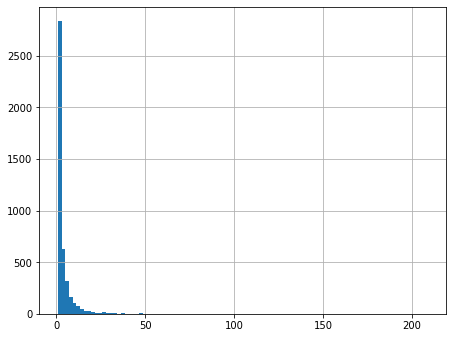

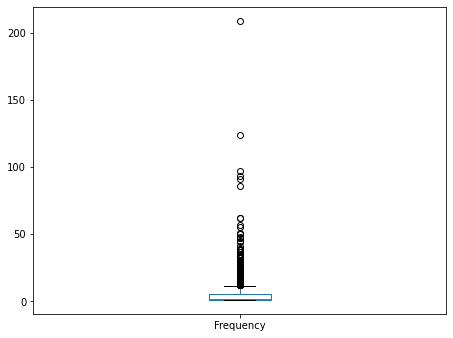

In [8]:
# Check frequency (not interesting)
print(cdf['Frequency'].describe())
print(cdf['Frequency'].quantile([.80, .85, .90, .95]))
plot(cdf['Frequency'].hist(bins=100))
plot(cdf['Frequency'].plot.box())

<AxesSubplot:xlabel='Monetary', ylabel='TotItems'>

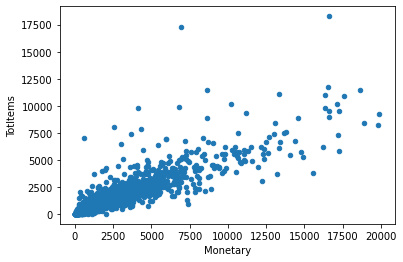

In [15]:
cdf[(cdf['Monetary'] < 20000) & (cdf['TotItems'] < 20000)].plot.scatter(x='Monetary', y='TotItems')